### Note: Max said he would grade this
# Optimal grokking: Exploring TrueGrad Adam implementations and normalized singular values

## Introduction
What is grokking? [Grokking](https://arxiv.org/pdf/2201.02177.pdf) is a curious phenomenon in neural networks. It in some sense spits in the face of classic understanding of training models. Rather than describe it, as they say, a picture is worth 1,000 words.

</br>

![](./grokking.png)

Taken from the research paper linked earlier, grokking is the behavior observed on some simple problems that long past overfitting, models almost suddenly generalize. And by long past overfitting, in this example we mean *long* past, nearly 4 orders of magnitude!

## Its not actually that bad!
Okay, so 4 orders of magnitude seem completely untenable, but this was the worst case described in the paper. Lets talk about the problem discussed in the paper a bit.
</br>

### So what is the problem described in the paper? What does the paper do?
### The problem (simplified)
Modular division </br>
* Choose some prime $P$, the paper chose $P=97$
* Generate all equations of the form $a+b \equiv c$ (mod $P)$
    * $a,b,c \in \mathbb{Z}^{0\leq P}$
* This will generate $N_{data} = P*P$ equations
    * Split the data into training and validating
* Train a standard TransformerDecoder of the following structure
    * Embedding layer with positional encoding (functionally an encoder)
    * 2 Layers
        * width 128
        * 4 attention heads
* With an Adam optimizer having parameters
    * learning rate $10^{-3}$
    * weight decay $10^{-2}$ - they said 1, but pretty sure they meant $1e-2$... 1 is insane
    * $B_1 = 0.9$, $B_2=0.98$

## The problem actually described in the paper
The problem described above is a lemma of what the paper actually does. This section is not required to understand anything we did, but we would be remiss if we did not talk about the finer details of the paper. </br>
* Not just modular division
    * $a \circ b \equiv c$(mod $P$) 
    * For the following ops
        *  $a \circ b$ $ = a + b$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a- b$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = [a/b$ (mod $P$) for $0 \leq a \le P$, $0 \le b \le P$
        *  $a \circ b$ $ = [a/b$ (mod $P$) if $b$ is odd, otherwise $a-b$ (mod $P$)] for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^2 + b^2$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^2 + ab + b^2$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^2 + ab + b^2 + a$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^3 + ab$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a^3 + ab^2 + b$ (mod $P$) for $0 \leq a,b \le P$
        *  $a \circ b$ $ = a * b$ for $a,b \in \mathbb{S}^5$
        *  $a \circ b$ $ = a * b * a^{-1}$ for $a,b \in \mathbb{S}^5$
        *  $a \circ b$ $ = a * b * a$ for $a,b \in \mathbb{S}^5$
* This means every input was 5 tokens
    * "a", "op", "b", "=", "c"
* Generate all equations of this form for some specific op
* Convert the 5 char arrays to 5 int arrays
* Split the data as before
* The transformer structure is unchanged
* They used a variety of optimization techniques and hyperparameter tuning
    * Minibatching and full batching
    * 10 warm up updates of mini batch size $[512, \frac{N_{trainingData}}{2}]$
    * optimization budget of $10^5$ gradient updates - I read this as steps.
    * learning rate $3e-4$, $3e-3$
    * weight decay same as before
    * Gaussian noise on weights
    * residual dropout 0.1
* They also put outliers in the dataset to see how this effected grokking

Importantly this reperesents a more full scope of what the study did. </br>
For our purposes we will just take some of their better presets as a base model.

## Results figure
![](./grokkingResults.png)
* Yes this is the worst graph in terms of labeling ever
* No the figure explanation does not help
* Below we talk about the key findings of the paper mostly ignoring this graph

## Key Results
* Adam is seemingly very important to grokking, at least momentum optimizers
* Grokking didn't happen until the singular values of weights became small
* Minibatching is superior
* Weight decay is *extremely* *extremely* important
* They didn't give precise results as far as We could tell
    * No statement that is this problem, this training data split, N optimization steps to train, M optimizations steps to grok
    * There exists some parameters such that grokking happens within an order of magnitude



## What we took from this as our base model
* The transformer model with dropout
* Adam optimizer 
    * $lr = 3e-4$
    * $weightDecay = 1e-2$
    * $B_1 = 0.9$, $B_2=0.98$
* Full batch training

Essentially this represented their best presets minus minibatching which preformed significantly better in their training. 



### Why didn't we do minibatching?
* We believe on intuition that TrueGrad Adam should be much more stable
* The best way to show this is to use the "worst" case for the optimizer
* Still good presets for Adam, but a hard situation

## Paper Implementation


### Used libraries for complete implementation
* [pytorch](https://github.com/pytorch/pytorch)
* [Tensorflow](https://github.com/tensorflow/tensorflow) (Just for mnist dataset)
* [numpy](https://github.com/numpy/numpy)
* [TrueGrad](https://github.com/ClashLuke/TrueGrad)
* [fasth](https://github.com/AlexanderMath/fasth)
* [pandas](https://github.com/pandas-dev/pandas)
* [matplotlib](https://matplotlib.org/)
#### All neccessary imports for paper re-implementation and analysis

In [12]:
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor
from torch.nn import Parameter
from typing import Optional, List, Tuple
import pandas as pd
import matplotlib.pyplot as plt
import os
from pathlib import Path

### Preset parameters from the paper

In [2]:
P = 97
DEVICE = "cuda"
D_MODEL = 128

### Data generation

Unlike the paper we generate the smaller verison so. So our data looks as follows
* $x \in x_{train}$ x = \[10, 17, 0\]
* corresponding y = \[10, 17, (10 + 17) % p \]
* Essentially x is just y without the answer
We split the data into training and validation to the specified amount of training data.
* $x_{train}, y_{train}$ are shape (n_training_data, 3)
* $x_{test}, y_{test}$ are shape ($P*P$ - n_training_data, 3)

In [3]:
def gen_data(n_training_data: int, p: int, device: str = "cuda"):
    # generate all possible equations for mod p
    all_data = []
    for i in range(p):
        for j in range(p):
           all_data.append([i,j,(i+j)%p])
    
    all_data = np.array(all_data)
    indices = np.random.permutation(all_data.shape[0])
    train_indices = indices[:n_training_data]
    valid_indices = indices[n_training_data:]
    
    input_seq: np.ndarray = all_data.copy()
    output_seq = input_seq.copy()
    input_seq[:, -1] = 0 # don't include answers

    train_x = torch.tensor(input_seq[train_indices]).long().to(device)
    train_y = torch.tensor(output_seq[train_indices]).long().to(device)
    valid_x = torch.tensor(input_seq[valid_indices]).long().to(device)
    valid_y = torch.tensor(output_seq[valid_indices]).long().to(device)

    return (train_x, train_y), (valid_x, valid_y)

### The embedding layer
Pytorch doesn't seem to have an embedding with position encoding built in yet. It might seem overkill to implement but transformers are permutation invariant which on a symmetric problem might give us an unfair advantage.

Our implementation is standard or positional encoding - we used the [following](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1/) as reference

In [4]:
class EmbeddingWithPE(torch.nn.Embedding):
    def __init__(self, num_embeddings: int, embedding_dim: int, seq_len: int, N: int= 10_000,
            padding_idx: Optional[int] = None, max_norm: Optional[float] = None,
            norm_type: float = 2.0, scale_grad_by_freq: bool = False, sparse: bool=False,
            device: Optional[torch.device] = None, dtype: Optional[torch.dtype] = None
        ):
        super().__init__(
            num_embeddings, embedding_dim, padding_idx, max_norm, norm_type,
            scale_grad_by_freq, sparse, device, dtype
        )
       
        pe = torch.zeros((seq_len, embedding_dim))
        buf = torch.arange(embedding_dim//2)
        denom = torch.pow(N, (2*buf)/embedding_dim)
        k = torch.arange(seq_len)
        pe[k, ::2] = torch.sin(k.unsqueeze(1)/denom)
        pe[k, 1::2] = torch.cos(k.unsqueeze(1)/denom)
        # pe should not be a learnable parameter, a buffer not a parameter
        self.register_buffer("pe", pe)
             

    def forward(self, x: Tensor) -> Tensor:
        return F.embedding(
            x, self.weight, self.padding_idx, self.max_norm,
            self.norm_type, self.scale_grad_by_freq, self.sparse) + self.pe

### The Transformer Model
Won't rehash the copying of the paper but will mention a few important things.
The paper stipulated a standard decoder so this is what we built, this includes masking and layernorms.

Also important is a decoder of width N will have an output layer with N neurons. We are classifying a number that is at most P which is num_embeddings. So we add a layer such that the final layer has num_embedding (P) outputs.

In [5]:
class Transformer(torch.nn.Module):
    def __init__(self, seq_length: int, num_embeddings: int, d_model: int, dim_feedforward: int = 2048):
        super().__init__()
        self.d_model = d_model
        self.num_embeddings = num_embeddings
        self.embed = EmbeddingWithPE(
            self.num_embeddings, self.d_model, seq_length)

        decoder_layer = torch.nn.TransformerDecoderLayer(self.d_model, nhead=4, dim_feedforward=dim_feedforward,
                                        dropout=0.1, batch_first=True, norm_first=True)
        decoder_norm = torch.nn.LayerNorm(self.d_model)

        self.decoder = torch.nn.TransformerDecoder(
            decoder_layer, num_layers=2, norm=decoder_norm)
        self.linear = torch.nn.Linear(
            self.d_model, self.num_embeddings, bias=False)
        self.mask = Parameter(
            torch.ones([seq_length, seq_length]).tril())

    def forward(self, x: Tensor) -> Tensor:
        x = self.embed(x)
        x = self.decoder.forward(x, torch.zeros_like(x), self.mask)
        return self.linear(x)

    def acc(self, prediction: Tensor, labels: Tensor):
        return (torch.argmax(prediction, dim=-2) == labels).float().mean()



### Training the model
Here we write a simple training loop to do full batch training of the model. We record the training losses and accuracie as well as the validation losses and accuracies. 

We use cross entropy because always use cross entropy.

In [6]:
def simple_train(
    model: Transformer,
    optimizer: torch.optim.Optimizer,
    train_x: Tensor,
    train_y: Tensor, 
    valid_x: Tensor, 
    valid_y: Tensor,
    epochs: int = 10_000,
    quiet: bool = False
) -> Tuple[ Tuple[List[Tensor], List[Tensor]],  Tuple[List[Tensor], List[Tensor]]  ]:
    
    """
    Simple training method, does full batch training on transformer model
    returns (train_accs, train_losses), (valid_accs, valid_losses) 
    where each list is length epochs
    """

    model.zero_grad()
    train_losses: List[Tensor] = []
    train_accs: List[Tensor] = []
    validation_losses: List[Tensor] = []
    validation_accs: List[Tensor] = []
    for i in range(epochs):
        optimizer.zero_grad()
        output = model.forward(train_x)
        print(output.shape)
        # model.forward shape is (n_inputs, 3, 97)
        # transpose to (n_inputs, 97, 3)
        pred = output.transpose(-2, -1)
        # -1: to not drop the dim
        pred = pred[..., -1:] 
        label = train_y[:, -1:]

        loss = F.cross_entropy(pred, label)
        acc = model.acc(pred, label)
        
        # keep track of losses
        train_accs.append(acc.item())
        train_losses.append(loss.item())
        
        with torch.no_grad():
            pred_valid = model.forward(valid_x).transpose(-2, -1)[..., -1:]
            label_valid = valid_y[:, -1:]
            valid_loss = F.cross_entropy(pred_valid, label_valid)
            valid_acc = model.acc(pred_valid, label_valid)
            validation_accs.append(valid_acc.item())
            validation_losses.append(valid_loss.item())
        if i % 100 == 0 and not quiet:
            print(f"Epoch {i}: loss {loss.item():e}, training_accuracy {acc}, valid_acc {valid_acc:4f}, valid_loss: {valid_loss:4f}")
        loss.backward()
        optimizer.step()
    
    return (train_accs, train_losses), (validation_accs, validation_losses)


### Training the model on a variety of parameters

We want to generate an amount of results to compare so we do grid search on the following parameters.
* N_epochs = 15,000
* n_training_data = 800 + 100k $k \in \mathbb{Z}^{0 \le 12}$
* d_model = \[64, 128, 256\]
* dim_feedforward = \[256, 512, 1024, 2048\]
</br>

This took 1.5 *days* of compute on an rtx 2060 12GB.
We save all fully trained models to do later analysis on their singular values as well the train and validation losses and accuracies.

The naming scheme for the saved files is
* .csv or .model depending on if its the model state dict or the training accuracies losses etcetera
* \<n_training_data\>_\<d_model\>_\<dim_feedforward\>
* To not confuse anyone from earlier d_model is the same as width from the paper

In [7]:
# For the sake of not running this biaccident we put this behind a function
def DO_NOT_RUN():
    for n_training_data in range(800, 2001, 100):
        # For consistency training data must be the same for the models of different params
        (train_x, train_y), (valid_x, valid_y) = gen_data(n_training_data, P, device=DEVICE)

        for d_model in [64, 128, 256]:
            for dim_feedforward in [256, 512, 1024, 2048]:
                model = Transformer(train_x.size(-1), P, d_model, dim_feedforward=dim_feedforward).to(DEVICE)

                optimizer = torch.optim.Adam(
                    model.parameters(),
                    lr=3e-4,
                    betas=[.9, .98],
                    weight_decay=1e-2,
                    eps=1e-8,
                    amsgrad=False,
                )
                print(f"Training model: n_train_data: {n_training_data}, d_model: {d_model} dim_feedforward: {dim_feedforward} ")
                (acc, loss), (valid_acc, valid_loss) = simple_train(model, optimizer, train_x, train_y, valid_x, valid_y, quiet=False,epochs=15_000)
                df_cols = ["Training Accuracy", "Training Loss", "Validation Accuracy", "Validation Loss"]
                df = pd.DataFrame(list(zip(acc, loss, valid_acc, valid_loss)), columns=df_cols)
                df.to_csv(f"output/{n_training_data}_{d_model}_{dim_feedforward}.csv")
                torch.save(model.state_dict(), f"output/{n_training_data}_{d_model}_{dim_feedforward}.model")

### Analysis of accuracies

First lets make a series plots as follows where <> denotes an immutable parameter
* (training_data, \<d_model=64\>, dim_feedforward)
* (training_data, \<d_model=128\>, dim_feedforward)
* (training_data, \<d_model=256\>, dim_feedforward)

So each set of plots is 13 by 4 and we can visually examine them before doing any statisical testing


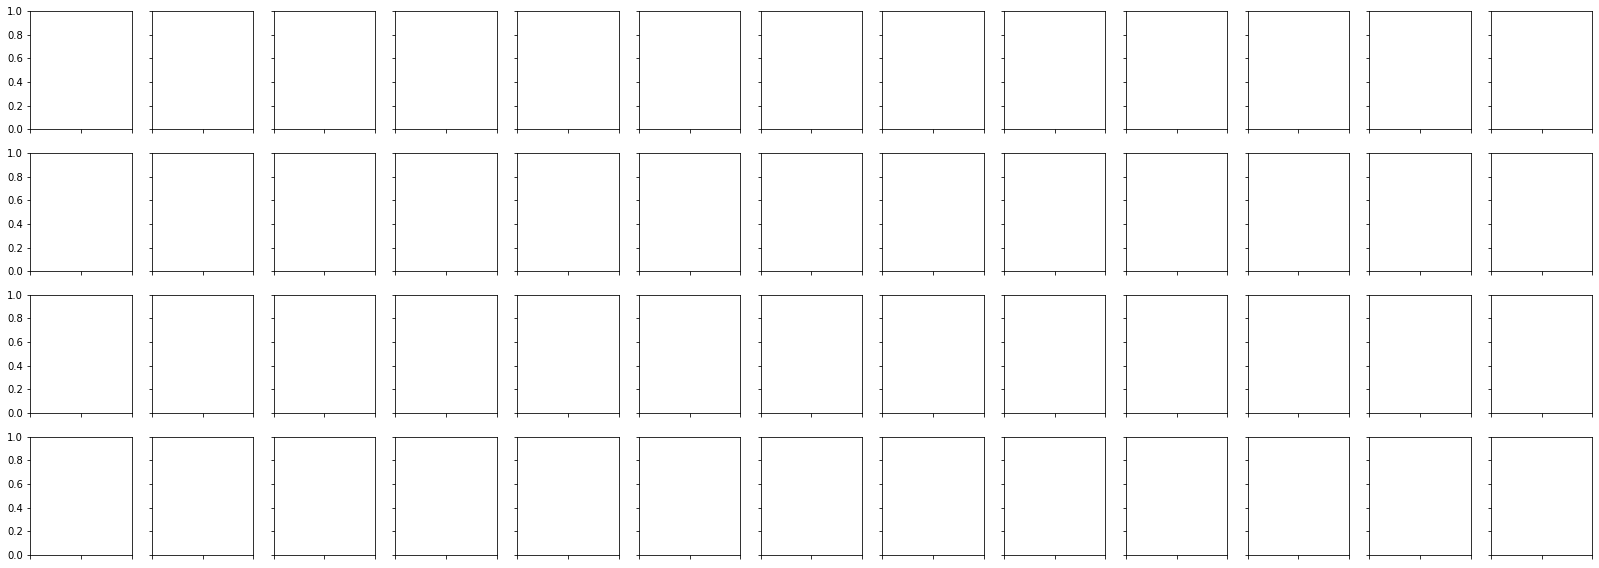

In [29]:
dataDir = Path("./output")
count=0
for fname in sorted(os.listdir(dataDir)):
    if fname.endswith("model"):
        continue
    fullPath = dataDir/Path(fname)
    count+=1
    #print(fullPath)
fig, ax = plt.subplots(4, 13)
for row in range(4):
    for col in range(13):
        csvName = f"output/{int(800+col*100)}_64_{int(2**row * 256)}.csv"
        plt.setp(ax[row][col].get_xticklabels(), visible=False)
        if col != 0:
            plt.setp(ax[row][col].get_yticklabels(), visible=False)
        df = pd.read_csv(csvName)
fig.set_size_inches(28, 10)

### So we have a base model 
* Roughly matches the paper
* Can we do better?
### We mentioned two methods
* TrueGrad adam
* Enforcing rules on the singular values
### Lets first explore singular values
* Relevant to the paper was that the model didn't seem to "grok" until the singular values became small
* Can we enforce this somehow?
    * Is this idea new?
    * No idea is new...
### Relevant lit.
#### Paper 1
* This [paper](https://arxiv.org/pdf/1611.06013.pdf) put a hard bound on singular values keeping them near 1
    * This preformed reasonably well 
    * But they have a problem! They have to somewhat regularly compute an svd composition to enforce the rules on their weight matrix!
        * This is extremely expensive!
#### Paper 2
* Another [paper](https://www.microsoft.com/en-us/research/wp-content/uploads/2013/01/svd_v2.pdf) use the svd to improve sparcity for generalization
    * This is (no pun) in some sense orthogonal to what we are doing, but an easily transferable task worth mentioning
* There actually isn't a ton of relevant literature on enforcing singular values (although there is a lot of research on orthogonal matrices and CNN's)
    * Why is this though?
    * We like to believe it is because methods involved computing the svd of the weights
    * this is prohibitively expensive
#### Paper 3
* But there is one very interesting paper!
* This beautiful [paper](https://arxiv.org/pdf/2009.13977.pdf) which recieved a neurips spotlight proposed SVD neural networks
* Essentially they represented each weight as its SVD decompositions ($U$, $S$, $V$) and trained them
    * This would be nice... but U and V must be orthogonal for this to make any sense
        * Regularization on gradient descent isn't enough!
        * We need math!
    * They represent $U$ and $V$ as a product of house holder matrices!
        * A householder matrix is a special orthogonal matrix which *stays orthogonal on gradient descent!!!!*
        * Limitations
            * $U$ $S$ $V$ doesn't necessarily span the most useful space when $U$ and $V$ must be householder matrices
        * Solution!
            * Any orthogonal matrix $A \in R^{(N, N)}$ can be represented by $N$ house holder matrices
        * Limitation of solution
            * Oh my god that turns the first layer of mnist into a minium of 784 matrix multiplications
        * They wrote the library mentioned at the top [fasth](https://github.com/AlexanderMath/fasth) which does the math much faster
        * Still not ideal
### Proposed ideas
* Okay we have some reasons to believe we might be able to accomplish the task
    * This looks like enforcing some "smallness" rules on our singular values
* Lets implement something things and test our assumptions


### Using householder matrices on mnist
* Mnist is great because its very learnable
#### Key limitation of householder
* You can *not* use momentum optimizers
* Householder matrices hold their properties on $SGD$ but non linear operators on the gradient break the properties
#### Householder defintion 

In [11]:
def householder(vector: Tensor):
    # assert column vector, just a good sanity check
    assert vector.shape[1] == 1
    assert len(vector.shape) == 2
    I = torch.eye(vector.shape[0])
    return I - 2*vector@vector.T/(vector.T@vector)

#### Implementation of Necessary classes
* Essentially we want a linear layer that stores the singular values
* It's useful to abstract the house holder matrices to modules
    * We can vary the number of house holder matrices later
#### Glossed over but non square weight matrices are annoying
* Defined as follows $W \in R^{(N, M)}$
    * $U \in R^{(N, N)}$, $S \in R^{(N, M)}$, $M \in R^{(M, M)}$

#### What the hell is setHouseOrthNHouseHolders!!!
* Why I'm glad you asked
* For reasons well beyond me I can't properly segment the parameters when using a parameter list
* So I write a function that outputs the houseOrth as a string with the right number of parameters
* We can then call exec on that object to set the number of house holder matrices
* I'm as upset as you are about this

In [416]:
import math
from torch.nn import init
#from torch import device, dtype
# A major todo is to verify this preserves the singular values 
# It doesn't really change the "hardness" of the problem
# But my math ability is questionable
# V @ (S.T @ (U @ x.T))#
class HouseOrth(torch.nn.Module):
    def __init__(self, N: int, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        # random initialization... this could be improved
        self.U = Parameter(householder(torch.empty(N,1, **factory_kwargs).uniform_(-1/math.sqrt(N), 1/math.sqrt(N))))
        
    def forward(self, x: Tensor):
        
        return self.U @ x.T

def setHouseOrthNHouseHolders(n_householders):
    """
    Father forgive me for I hath sinned
    """
    u = [f"\t\tself.U{i} = Parameter(householder(torch.empty(N,1, **factory_kwargs).uniform_(-1/math.sqrt(N), 1/math.sqrt(N))))" for i in range(n_householders)]
    u = '\n'.join(u)
    u = u.replace("\t", " "*4)
    def helper(i):
        if i == 0:
            return "self.U0 @ x.T"
        return f"self.U{i} @ ({helper(i-1)})"

    s = f"""
class HouseOrth(torch.nn.Module):
    def __init__(self, N: int, device=None, dtype=None):
        factory_kwargs = {{'device': device, 'dtype': dtype}}
        super().__init__()
        # random initialization... this could be improved
{u}
    def forward(self, x: Tensor):
        
        return {helper(n_householders-1)}
    """
    

    return s


class LinearSVD(torch.nn.Module):
    def __init__(self, in_features: int, out_features: int, bias: bool = True, device=None, dtype=None):
        factory_kwargs = {'device': device, 'dtype': dtype}
        super().__init__()
        N,M = in_features, out_features
        self.in_features = in_features
        self.out_features = out_features
        self.U = HouseOrth(N, **factory_kwargs)
        # we normalize the singular values in the multiplication - smart initialization probably doesn't matter too much
        # and if it does we do not know what that would be
        self.singulars = Parameter(torch.empty(M, **factory_kwargs).uniform_(-1/math.sqrt(out_features), 1/math.sqrt(in_features)))
        self.register_buffer("S", torch.eye(N,M, **factory_kwargs)) # singulars are trainable - the matrix isn't (only the diagonal are parameters)
        self.V = HouseOrth(M, **factory_kwargs) # Whether or not this is transposed doesn't really matter - its valid either way just a diff matrix
        # copy torch.nn.Linear for what its worth here
        if bias:
            self.bias = Parameter(torch.empty((out_features,), **factory_kwargs) )
            #step = self.U()
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.V(self.U( (self.singulars*self.S).T)))
            bound = 1 / math.sqrt(fan_in) if fan_in > 0 else 0
            init.uniform_(self.bias, -bound, bound)
        else:
            self.register_parameter('bias', None)

    def forward(self, x: Tensor) -> Tensor:
        return self.V( ((self.singulars * self.S).T @ self.U(x)).T ).T + self.bias
    


#### Test how well this learns on full batch mnist
* Use simple linear model

In [417]:
import tensorflow.keras.datasets.mnist as mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = torch.tensor(x_train).cuda().reshape(x_train.shape[0], math.prod(x_train.shape[1:])).float() #/ 255 # normalize b/c uh this is prolly smart?
y_train = torch.tensor(y_train).cuda()

x_test = torch.tensor(x_test).cuda().reshape(x_test.shape[0], math.prod(x_test.shape[1:])).float()
y_test = torch.tensor(y_test).cuda()

In [418]:
class Model(torch.nn.Module):
    def __init__(self, useSVD=True):
        super().__init__()
        if useSVD:
            Linear = LinearSVD
        else:
            Linear = torch.nn.Linear
        self.fc1 = Linear(784, 128)
        self.fc2 = Linear(128, 128)
        self.fc3 = Linear(128, 10)
    
    def forward(self, x: Tensor):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.softmax(self.fc3(x), -1)

#### Compare linearSVD with Linear
* We cannot use Adam on HouseOrth
* We can on singulars
* We do not care about generalization on mnist
    * Only inspecting training accuracies

In [419]:
def segmentHouseHolderParameters(model: torch.nn.Module):
    """
    Returns tuple[0] = HouseParameters for SGD optimizer 
    tuple[1] = All other Parameters for Adam
    """
    houseParams: List[Parameter] = []
    otherParams: List[Parameter] = []
    for module in model.modules():
        if isinstance(module, HouseOrth):
            # parameter lists... needs to be true apparently... honest to god not sure why
            # but since HouseOrth is a base module it doesn't cause errors
            for p in module.parameters(False): houseParams.append(p) 
        else:
            for p in module.parameters(False): otherParams.append(p)
    return houseParams, otherParams

def getOptimizers(model: torch.nn.Module):
    """
    Optimizers get unhappy when you give them an empty list, so we don't do that
    Just an abstraction to avoid rewriting a lot of code
    """
    hParams, nParams = segmentHouseHolderParameters(model)
    optimizers: List[torch.optim.Optimizer] = []
    if len(hParams) != 0:
        optimizers.append(torch.optim.SGD(hParams, lr=3e-3))
    if len(nParams) != 0:
        optimizers.append(torch.optim.Adam(nParams, lr=3e-4))
    return optimizers 



In [420]:
def minibatchTrain(model: torch.nn.Module, optimizers: List[torch.optim.Optimizer], epochs: int = 100, batch_size: int = 1000) -> List[Tensor]:
    """
    Train the model, return list of accuracies
    the optimizers are a list because we want to be able to use different optimizers
    on different parameters in the network. 

    Our problem doesn't do minibatching - but not minibatching makes result pretty unstable so for testing we use minibatching.
    Note: I refuse to learn how to use pytorch's dataloader it confused me once 4 years ago and I took it personally.
    Note: Yes the batch size is non standard but idk divisible by 60k is nice
    """
    accuracies = []
    samples = x_train.shape[0]
    n_batches = samples // batch_size
    for i in range(epochs):
        perm = np.random.permutation(samples) # switch order every epoch generally good practice
        for batch in range(n_batches):
            x = x_train[perm[batch*batch_size:(batch+1)*batch_size]]
            y = y_train[perm[batch*batch_size:(batch+1)*batch_size]]
            for opt in optimizers: opt.zero_grad()
            pred = model(x)
            loss = F.cross_entropy(pred, y)
            loss.backward()
            for opt in optimizers: opt.step()
        with torch.no_grad():
            acc = (torch.argmax(model(x_train), -1) == y_train).float().mean()
            accuracies.append(acc.clone().detach().cpu().numpy())
    return accuracies


In [425]:
# normal linear model
standardModel = Model(useSVD=False).cuda()
standardOpt = getOptimizers(standardModel)
standardAcc = minibatchTrain(standardModel, standardOpt)
#setHouseOrthNHouseHolders(2)
# svd linear model
s = setHouseOrthNHouseHolders(20)
exec(s) # yes this is insane
svdModel = Model(useSVD=True).cuda()
svdOpt = getOptimizers(svdModel)
svdAcc = minibatchTrain(svdModel, svdOpt)


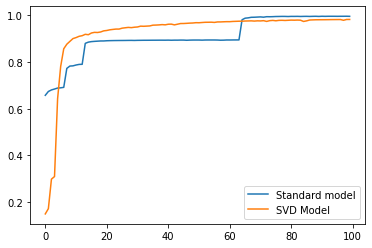

In [426]:
fig, ax = plt.subplots()
# plotting
x = np.arange(len(standardAcc))
ax.plot(x, standardAcc, label="Standard model")
ax.plot(x, svdAcc, label = "SVD Model")
ax.legend()

### Yea this isn't perfect!
* But it does learn!
* We managed to restrict the space *considerably*
    * We can make the learnable space larger by using more house holder matrices for $U$ and $V$
### The sane way to do this is a parameter list
* For the love of god I don't know why this causes problems
* But when I segment the parameters it doesn't work right...
    * U and V loose the fact they are orthgonal
* Solving this is insane
    * But we perservere
### Write a function that outputs a new HouseOrth class
* This houseOrth class will have the correct number of parameters

In [428]:

(svdModel.fc1.U.U5 @ svdModel.fc1.U.U5.T - torch.eye(784).cuda()).abs().max()

tensor(0.0068, device='cuda:0', grad_fn=<MaxBackward1>)

In [429]:

(svdModel.fc1.U.U15 @ svdModel.fc1.U.U15.T - torch.eye(784).cuda()).abs().max()

tensor(0.0105, device='cuda:0', grad_fn=<MaxBackward1>)

In [315]:
t = svdModel.fc1.V.U1
print((t @ t.T - torch.eye(128).cuda()).abs().max())
t = svdModel.fc1.V.U2
(t @ t.T - torch.eye(128).cuda()).abs().max()

tensor(0.0675, device='cuda:0', grad_fn=<MaxBackward1>)


tensor(0.0713, device='cuda:0', grad_fn=<MaxBackward1>)

In [328]:
segmentHouseHolderParameters(Model(useSVD=True))[0]

[Parameter containing:
 tensor([[     0.9970,     -0.0017,     -0.0029,  ...,      0.0021,
              -0.0045,     -0.0004],
         [    -0.0017,      0.9991,     -0.0016,  ...,      0.0012,
              -0.0025,     -0.0002],
         [    -0.0029,     -0.0016,      0.9972,  ...,      0.0021,
              -0.0043,     -0.0004],
         ...,
         [     0.0021,      0.0012,      0.0021,  ...,      0.9985,
               0.0032,      0.0003],
         [    -0.0045,     -0.0025,     -0.0043,  ...,      0.0032,
               0.9934,     -0.0006],
         [    -0.0004,     -0.0002,     -0.0004,  ...,      0.0003,
              -0.0006,      0.9999]], requires_grad=True),
 Parameter containing:
 tensor([[     0.9865,     -0.0247,     -0.0122,  ...,      0.0009,
               0.0089,     -0.0100],
         [    -0.0247,      0.9551,     -0.0223,  ...,      0.0016,
               0.0163,     -0.0183],
         [    -0.0122,     -0.0223,      0.9890,  ...,      0.0008,
          

In [349]:
s ="""
class Dummy:
    pass
"""
print(exec(s.strip()))

None
